In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from tld import get_tld, is_tld

In [2]:
data=pd.read_csv("/Users/arda/Documents/malicious-phishing/malicious_phish.csv")
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [4]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [5]:
count=data.type.value_counts()
count

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

Text(0, 0.5, 'Count')

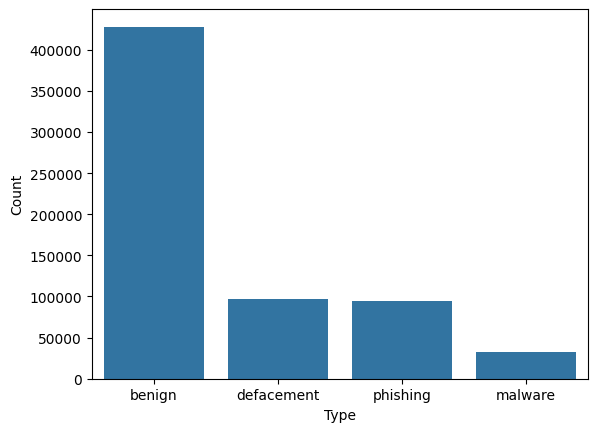

In [6]:
sns.barplot(x=count.index, y=count)
plt.xlabel("Type")
plt.ylabel("Count")

In [7]:
data["url"]=data["url"].replace("www.", "", regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [8]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [9]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}}
data["Category"] = data["type"]
data = data.replace(rem)

/var/folders/b6/74m34wq95_77qp6pbrg1fx9m0000gn/T/ipykernel_40457/888585881.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


In [10]:
data["url_len"]=data["url"].apply(lambda x: len(str(x)))

In [11]:
def process_tld(url):
    try:
        res=get_tld(url,as_object=True,fail_silently=False,fix_protocol=True)
        pri_domain=res.parsed_url.netloc
    except:
        pri_domain=None
    return pri_domain
data["domain"]=data["url"].apply(lambda i: process_tld(i))
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [12]:
feature={"@","-",".","_","/",":","?","=","&","+","!","*","%","$","#"}
for a in feature:
    data[f"url_{a}"] = data["url"].apply(lambda i: i.count(a))

In [13]:
data.head()

,url,type,Category,url_len,domain,url_=,url_*,url_&,url_-,url_+,url_@,url_:,url_.,url_/,url_?,url__,url_!,url_$,url_%,url_#
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,0,0,0,2,2,0,1,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,4,0,3,1,0,0,1,2,3,1,2,0,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,3,0,2,1,0,0,1,2,3,1,1,0,0,0,0


In [14]:
def abnormal_url(url):
    hostname=urlparse(url).hostname
    hostname=str(hostname)
    match=re.search(hostname, url)
    if match:
        return 1
    else:
        return 0

In [15]:
data["abnormal_url"] = data["url"].apply(lambda i: abnormal_url(i))

<Axes: xlabel='abnormal_url', ylabel='count'>

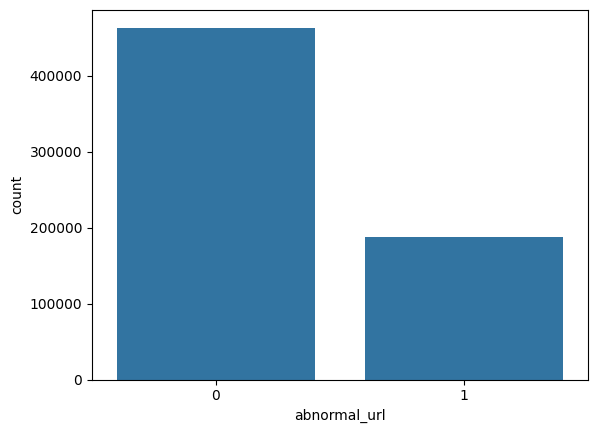

In [16]:
sns.countplot(x="abnormal_url", data=data)

In [17]:
def httpSecure(url):
    htp=urlparse(url).scheme
    match=str(htp)
    if match=="https":
        return 1
    else:
        return 0

In [18]:
data["https"] = data["url"].apply(lambda i: httpSecure(i))

<Axes: xlabel='https', ylabel='count'>

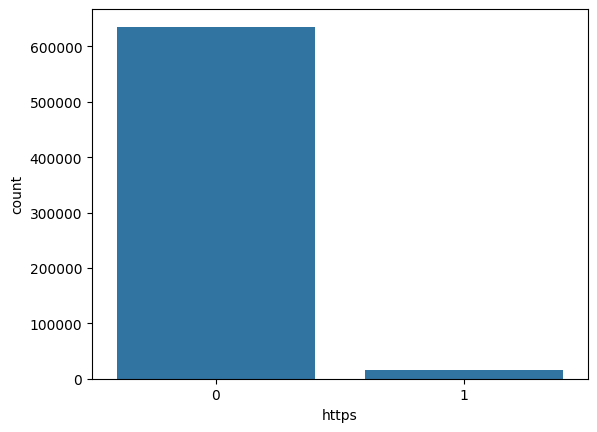

In [19]:
sns.countplot(x="https", data=data)

In [20]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits=digits+1
    return digits

In [21]:
data["digits"]=data["url"].apply(lambda i: digit_count(i))

In [22]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters=letters+1
    return letters

In [23]:
data["letters"]=data["url"].apply(lambda i: letter_count(i))

In [24]:
def shortning_Service(url):
    match = re.search(r"(bit\.ly|tinyurl\.com|goo\.gl|t\.co|ow\.ly|is\.gd|buff\.ly|adf\.ly|rebrand\.ly|tiny\.cc|su\.pr|mcaf\.ee)", url)
    if match:
        return 1
    else:
        return 0

/var/folders/b6/74m34wq95_77qp6pbrg1fx9m0000gn/T/ipykernel_40457/2603208971.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='shortning_service', data=data, palette=['#2ecc71', '#e74c3c'])


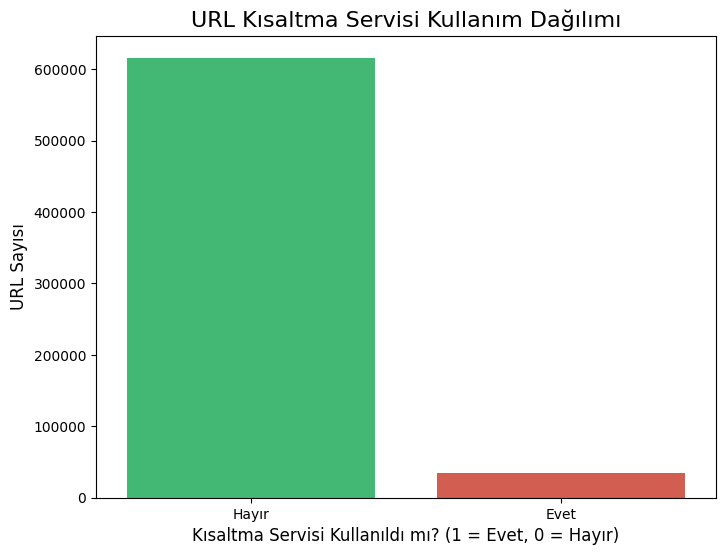

In [25]:
data['shortning_service'] = data['url'].apply(lambda i: shortning_Service(i))

# Sonucu bir çubuk grafiği ile görselleştir
plt.figure(figsize=(8, 6))
sns.countplot(x='shortning_service', data=data, palette=['#2ecc71', '#e74c3c'])
plt.title('URL Kısaltma Servisi Kullanım Dağılımı', fontsize=16)
plt.xlabel('Kısaltma Servisi Kullanıldı mı? (1 = Evet, 0 = Hayır)', fontsize=12)
plt.ylabel('URL Sayısı', fontsize=12)
plt.xticks([0, 1], ['Hayır', 'Evet'])
plt.show()

In [26]:
x=data.drop(columns=["url","domain","type","Category"],axis=1)
y=data["Category"]

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=2)

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/var/folders/b6/74m34wq95_77qp6pbrg1fx9m0000gn/T/ipykernel_40457/4179352640.py:11: SyntaxWarning: invalid escape sequence '\ '
  print("######- model = > \ 033 {} \033".format(m))


####################################
######- model = > \ 033 <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test accuracy :    91.72 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.81      0.62      0.70     18805
           3       0.95      0.92      0.93      6550

    accuracy                           0.92    130239
   macro avg       0.91      0.87      0.88    130239
weighted avg       0.91      0.92      0.91    130239

                Confusion_matrix  ]0m


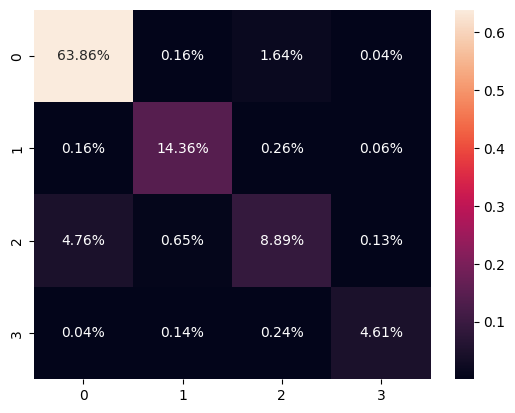

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test accuracy :    92.42 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     85565
           1       0.95      0.97      0.96     19319
           2       0.84      0.63      0.72     18805
           3       0.97      0.92      0.94      6550

    accuracy                           0.92    130239
   macro avg       0.92      0.87      0.89    130239
weighted avg       0.92      0.92      0.92    130239

                Confusion_matrix  ]0m


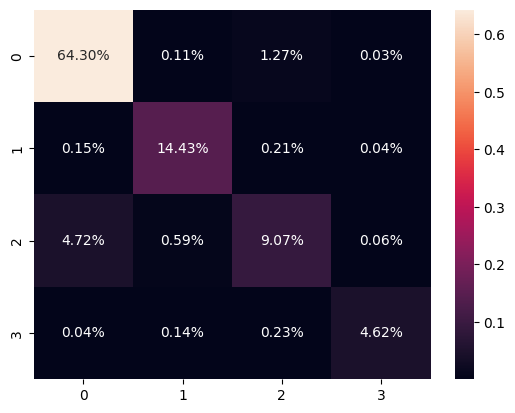

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test accuracy :    80.54 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     85565
           1       0.70      0.92      0.80     19319
           2       0.35      0.05      0.09     18805
           3       0.82      0.47      0.60      6550

    accuracy                           0.81    130239
   macro avg       0.68      0.60      0.60    130239
weighted avg       0.75      0.81      0.76    130239

                Confusion_matrix  ]0m


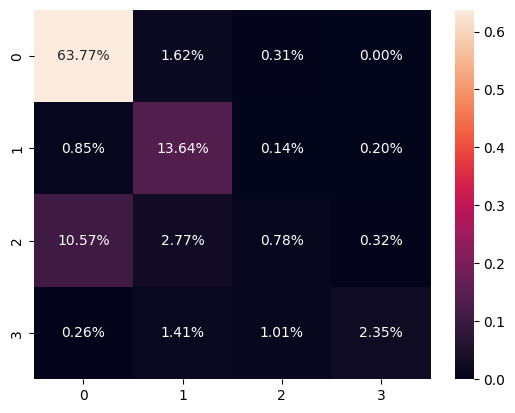

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.neighbors._classification.KNeighborsClassifier'> 
Test accuracy :    89.63 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     85565
           1       0.90      0.95      0.92     19319
           2       0.75      0.57      0.64     18805
           3       0.94      0.88      0.91      6550

    accuracy                           0.90    130239
   macro avg       0.88      0.84      0.85    130239
weighted avg       0.89      0.90      0.89    130239

                Confusion_matrix  ]0m


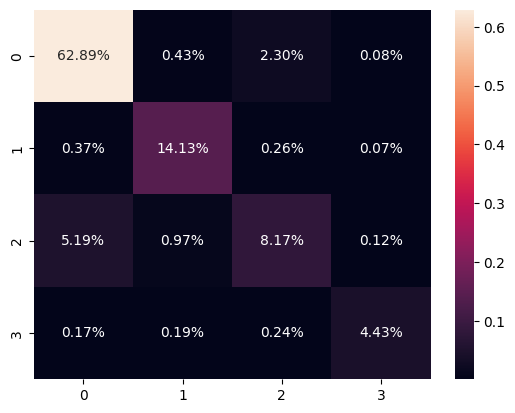

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test accuracy :    81.46 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.82      0.99      0.90     85565
           1       0.83      0.88      0.85     19319
           2       0.42      0.06      0.11     18805
           3       0.87      0.48      0.62      6550

    accuracy                           0.81    130239
   macro avg       0.74      0.60      0.62    130239
weighted avg       0.77      0.81      0.76    130239

                Confusion_matrix  ]0m


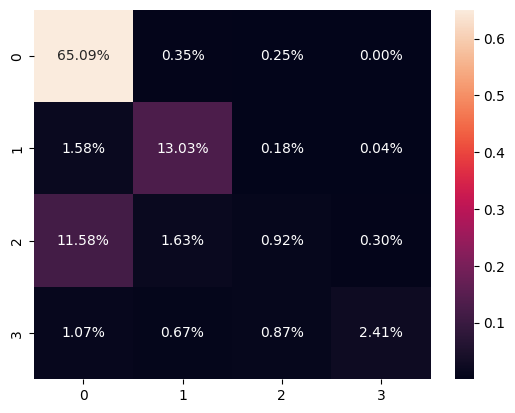

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test accuracy :    92.45 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     85565
           1       0.94      0.97      0.96     19319
           2       0.85      0.62      0.72     18805
           3       0.98      0.92      0.95      6550

    accuracy                           0.92    130239
   macro avg       0.92      0.87      0.89    130239
weighted avg       0.92      0.92      0.92    130239

                Confusion_matrix  ]0m


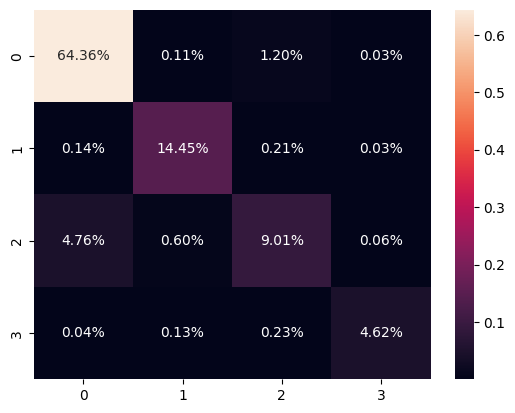

 ########################## - End -######################]0m
####################################
######- model = > \ 033 <class 'sklearn.naive_bayes.GaussianNB'> 
Test accuracy :    77.07 ]30m ]0m
                Classification_Report  ]0m
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     85565
           1       0.61      1.00      0.76     19319
           2       0.52      0.02      0.04     18805
           3       0.44      0.34      0.38      6550

    accuracy                           0.77    130239
   macro avg       0.60      0.57      0.52    130239
weighted avg       0.74      0.77      0.72    130239

                Confusion_matrix  ]0m


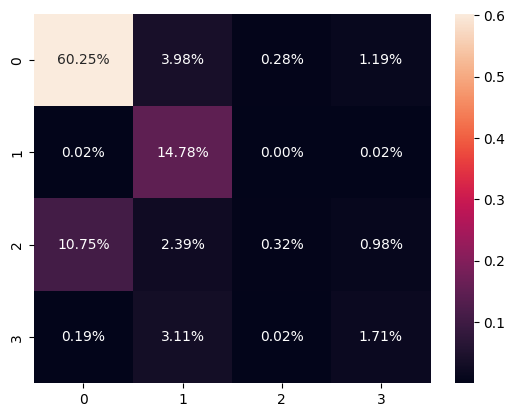

 ########################## - End -######################]0m


In [29]:
from regex import P


models = [DecisionTreeClassifier, RandomForestClassifier, AdaBoostClassifier, KNeighborsClassifier, SGDClassifier,
         ExtraTreesClassifier, GaussianNB]

accuracy_test = []

for m in models:
    print("####################################")
    print("######- model = > \ 033[07m {} \033[0m".format(m))

    model = m()

    model.fit(x_train, y_train)

    pred = model.predict(x_test)
    acc = accuracy_score(pred, y_test)

    accuracy_test.append(acc)

    print("Test accuracy : \033[32m \033[01m  {:.2f} \033]30m \033]0m".format(acc*100))   
    print("\033[01m                Classification_Report  \033]0m") 
    print(classification_report(y_test,pred))
    print("\033[01m                Confusion_matrix  \033]0m")
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt="0.2%")
    plt.show()
    print("\033 [31m########################## - End -######################\033]0m")